In [1]:
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 


In [2]:
batch_size = 1
device="cuda" if torch.cuda.is_available() else "cpu"
train_data = datasets.MNIST(root="../data", train=True, 
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(root="../data", train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

In [3]:
import torch.nn.functional as F

In [35]:
class Encoder(nn.Module):
    def __init__(self, dim_x, dim_y, dim_z):

        super().__init__()
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1,padding='same')
        self.layer4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=2,padding=0)
        self.layer6 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1,padding='same')
        self.layer8 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=2,padding=0)
        self.layer10 = nn.Conv2d(in_channels=64, out_channels=80, kernel_size=7, stride=1,padding='valid')
        self.lin1 = nn.Linear(in_features=90, out_features=40)
        self.lin1 = nn.Linear(in_features=40, out_features=20)
    
    def forward(self, inputs):
        x = inputs[0].unsqueeze(dim=0).to(device)#.unsqueeze(dim=0)
        y = torch.tensor(inputs[1], dtype=torch.int64).unsqueeze(dim=0).to(device)
        y = F.one_hot(y, 10)
        print(f"img shape: {x.shape}, labels shape: {y.shape}")
        x = F.leaky_relu(self.layer1(x))
        print(x.shape)
        # 32, 28, 28
        x = F.pad(x, (0,3,0,3))
        print(x.shape)
        # 32, 31, 31
        x = self.layer4(x)
        print(x.shape)
        # 32, 14, 14
        x = F.leaky_relu(x)
        x = self.layer6(x)
        print(x.shape)
        # 64, 14, 14
        x = F.pad(x, (0,3,0,3))
        print(x.shape)
        # 64, 17, 17
        x = self.layer8(x)
        print(x.shape)
        # 64, 7, 7
        x = F.leaky_relu(x)
        x = self.layer10(x)
        print(x.shape)
        # 80, 1, 1
        x = x.view(-1)
        print(x.shape)
        x = torch.cat((x, y.squeeze(dim=0)), dim=0)
        print(x.shape)
        x = self.lin1(x)
        print(x.shape)
        x = self.lin2(x)
        print(x.shape)
        return x

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"

3
img shape: torch.Size([1, 1, 28, 28]), labels shape: torch.Size([1, 10])
torch.Size([1, 32, 28, 28])
torch.Size([1, 32, 31, 31])
torch.Size([1, 32, 14, 14])
torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 17, 17])
torch.Size([1, 64, 7, 7])
torch.Size([1, 80, 1, 1])
torch.Size([80])
torch.Size([90])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x90 and 40x20)

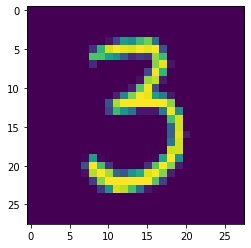

In [37]:
model = Encoder(dim_x=28, dim_y=10, dim_z=20).to(device)     
i=50
img=train_data[i][0]
lbl=train_data[i][1]
plt.imshow(img.squeeze())
print(lbl)
inputs=(img, lbl)
out = model(inputs)
#
# lblon

In [ ]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

In [ ]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# # Import tqdm for progress bar
# from tqdm.auto import tqdm

# # Set the seed and start the timer
# torch.manual_seed(42)

# # Set the number of epochs (we'll keep this small for faster training times)
# epochs = 50

# # Create training and testing loop
# for epoch in tqdm(range(epochs)):
#     print(f"Epoch: {epoch}\n-------")
#     ### Training
#     train_loss = 0
#     # Add a loop to loop through training batches
#     for batch, (X, y) in enumerate(train_dataloader):
#         model.train() 
#         # 1. Forward pass
#         X = X.to(device)
#         y = y.to(device)
#         y = torch.nn.functional.one_hot(y, 10).to(torch.float32)
#         y_pred = model(X)
        
#         # 2. Calculate loss (per batch)
#         loss = loss_fn(y_pred, y)
#         train_loss += loss # accumulatively add up the loss per epoch 

#         # 3. Optimizer zero grad
#         optimizer.zero_grad()

#         # 4. Loss backward
#         loss.backward()

#         # 5. Optimizer step
#         optimizer.step()

#         # Print out how many samples have been seen
#         if batch % 400 == 0:
#             print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

#     # Divide total train loss by length of train dataloader (average loss per batch per epoch)
#     train_loss /= len(train_dataloader)
    
#     ### Testing
#     # Setup variables for accumulatively adding up loss and accuracy 
#     test_loss, test_acc = 0, 0 
#     model.eval()
#     with torch.inference_mode():
#         for X, y in test_dataloader:
#             X = X.to(device)
#             y = y.to(device)    
#             y = torch.nn.functional.one_hot(y, 10).to(torch.float32)
#             # 1. Forward pass
#             test_pred = model(X)
           
#             # 2. Calculate loss (accumatively)
#             test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

#             # 3. Calculate accuracy (preds need to be same as y_true)
#             test_acc += accuracy_fn(y_true=y.argmax(dim=1), y_pred=test_pred.argmax(dim=1))
        
#         # Calculations on test metrics need to happen inside torch.inference_mode()
#         # Divide total test loss by length of test dataloader (per batch)
#         test_loss /= len(test_dataloader)

#         # Divide total accuracy by length of test dataloader (per batch)
#         test_acc /= len(test_dataloader)

#     ## Print out what's happening
#     print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


In [18]:
y = torch.tensor(inputs[1], dtype=torch.int8).unsqueeze(dim=0)
y.shape

torch.Size([1])

In [17]:
y=y.unsqueeze(dim=0)
y.shape

torch.Size([1])

In [28]:
F.one_hot(5, 10)

TypeError: one_hot(): argument 'input' (position 1) must be Tensor, not int